In [1]:
!pip install imbalanced-learn
!pip install seaborn
!pip install lime

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.utils import shuffle
from tensorflow.keras import layers, models, Input
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image as keras_image
from lime.lime_image import LimeImageExplainer


2025-02-24 08:50:13.657458: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 08:50:13.686755: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 08:50:13.686783: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 08:50:13.686808: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 08:50:13.693161: I tensorflow/core/platform/cpu_feature_g

In [3]:
def file_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

def create_df(tr_dir, val_dir, ts_dir):
    train_files, train_classes = file_paths(tr_dir)
    train_df = define_df(train_files, train_classes)

    val_files, val_classes = file_paths(val_dir)
    valid_df = define_df(val_files, val_classes)

    test_files, test_classes = file_paths(ts_dir)
    test_df = define_df(test_files, test_classes)
    
    return train_df, valid_df, test_df

In [4]:
def create_data_generators(train_df, valid_df, test_df, batch_size):
    image_size = (224, 224)
    num_channels = 3
    image_shape = (image_size[0], image_size[1], num_channels)
    
    test_len = len(test_df)
    optimal_test_batch_size = max([test_len // n for n in range(1, test_len + 1) if test_len % n == 0 and test_len / n <= 80])
    test_steps = test_len // optimal_test_batch_size

    def preprocess_image(img):
        return img

   
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_image, horizontal_flip=True)
    valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    valid_generator = valid_test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    test_generator = valid_test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,
        batch_size=optimal_test_batch_size
    )

    return train_generator, valid_generator, test_generator

In [5]:
def display_images(generator):
    
    class_dict = generator.class_indices
    class_names = list(class_dict.keys())

    
    images, labels = next(generator)

  
    plt.figure(figsize=(20, 20))
    num_images = len(labels)
    num_samples = min(num_images, 25)

   
    for i in range(num_samples):
        plt.subplot(5, 5, i + 1)
        img = images[i] / 255.0  
        plt.imshow(img)
        
        
        class_index = np.argmax(labels[i])
        class_label = class_names[class_index]

        
        plt.title(class_label, color='blue', fontsize=12)
        plt.axis('off')

   
    plt.show()

In [6]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, initial_epoch, epochs):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience 
        self.stop_patience = stop_patience 
        self.threshold = threshold 
        self.factor = factor 
        self.batches = batches 
        self.initial_epoch = initial_epoch
        self.epochs = epochs

        self.count = 0 
        self.stop_count = 0
        self.best_epoch = 1  
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) 
        self.highest_tracc = 0.0 
        self.lowest_vloss = np.inf 
        self.best_weights = self.model.get_weights() 
        self.initial_weights = self.model.get_weights()   

   
    def on_train_begin(self, logs= None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') 

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
        current_lr = lr
        acc = logs.get('accuracy')  
        v_acc = logs.get('val_accuracy')  
        loss = logs.get('loss')  
        v_loss = logs.get('val_loss')  

        if acc < self.threshold: 
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc 

            if acc > self.highest_tracc: 
                self.highest_tracc = acc 
                self.best_weights = self.model.get_weights()
                self.count = 0 
                self.stop_count = 0 
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  

            else:
              
                if self.count >= self.patience - 1: 
                    lr = lr * self.factor 
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) 
                    self.count = 0 
                    self.stop_count = self.stop_count + 1 
                    self.count = 0 
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 
        else: 
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: 
                self.lowest_vloss = v_loss #
                self.best_weights = self.model.get_weights() 
                self.count = 0 
                self.stop_count = 0
                self.best_epoch = epoch + 1 
            else: 
                if self.count >= self.patience - 1: 
                    lr = lr * self.factor 
                    self.stop_count = self.stop_count + 1 
                    self.count = 0 #
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) 
                else:
                    self.count = self.count + 1
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: 
            msg = f' training stopped at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True 

In [7]:
def plot_training_metrics(history):
    training_accuracy = history.history['accuracy']
    training_loss = history.history['loss']
    validation_accuracy = history.history['val_accuracy']
    validation_loss = history.history['val_loss']

    
    best_epoch_loss = np.argmin(validation_loss) + 1
    best_epoch_accuracy = np.argmax(validation_accuracy) + 1
    lowest_val_loss = validation_loss[best_epoch_loss - 1]
    highest_val_acc = validation_accuracy[best_epoch_accuracy - 1]

    
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')
    epochs = range(1, len(training_accuracy) + 1)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, 'r', label='Training Loss')
    plt.plot(epochs, validation_loss, 'g', label='Validation Loss')
    plt.scatter(best_epoch_loss, lowest_val_loss, s=150, c='blue', label=f'Best Epoch = {best_epoch_loss}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, 'r', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'g', label='Validation Accuracy')
    plt.scatter(best_epoch_accuracy, highest_val_acc, s=150, c='blue', label=f'Best Epoch = {best_epoch_accuracy}')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()  
    plt.show()

In [8]:
def display_confusion_matrix(cm, class_names, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)

   
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > threshold else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Found 1843 validated image filenames belonging to 2 classes.
Found 235 validated image filenames belonging to 2 classes.
Found 437 validated image filenames belonging to 2 classes.


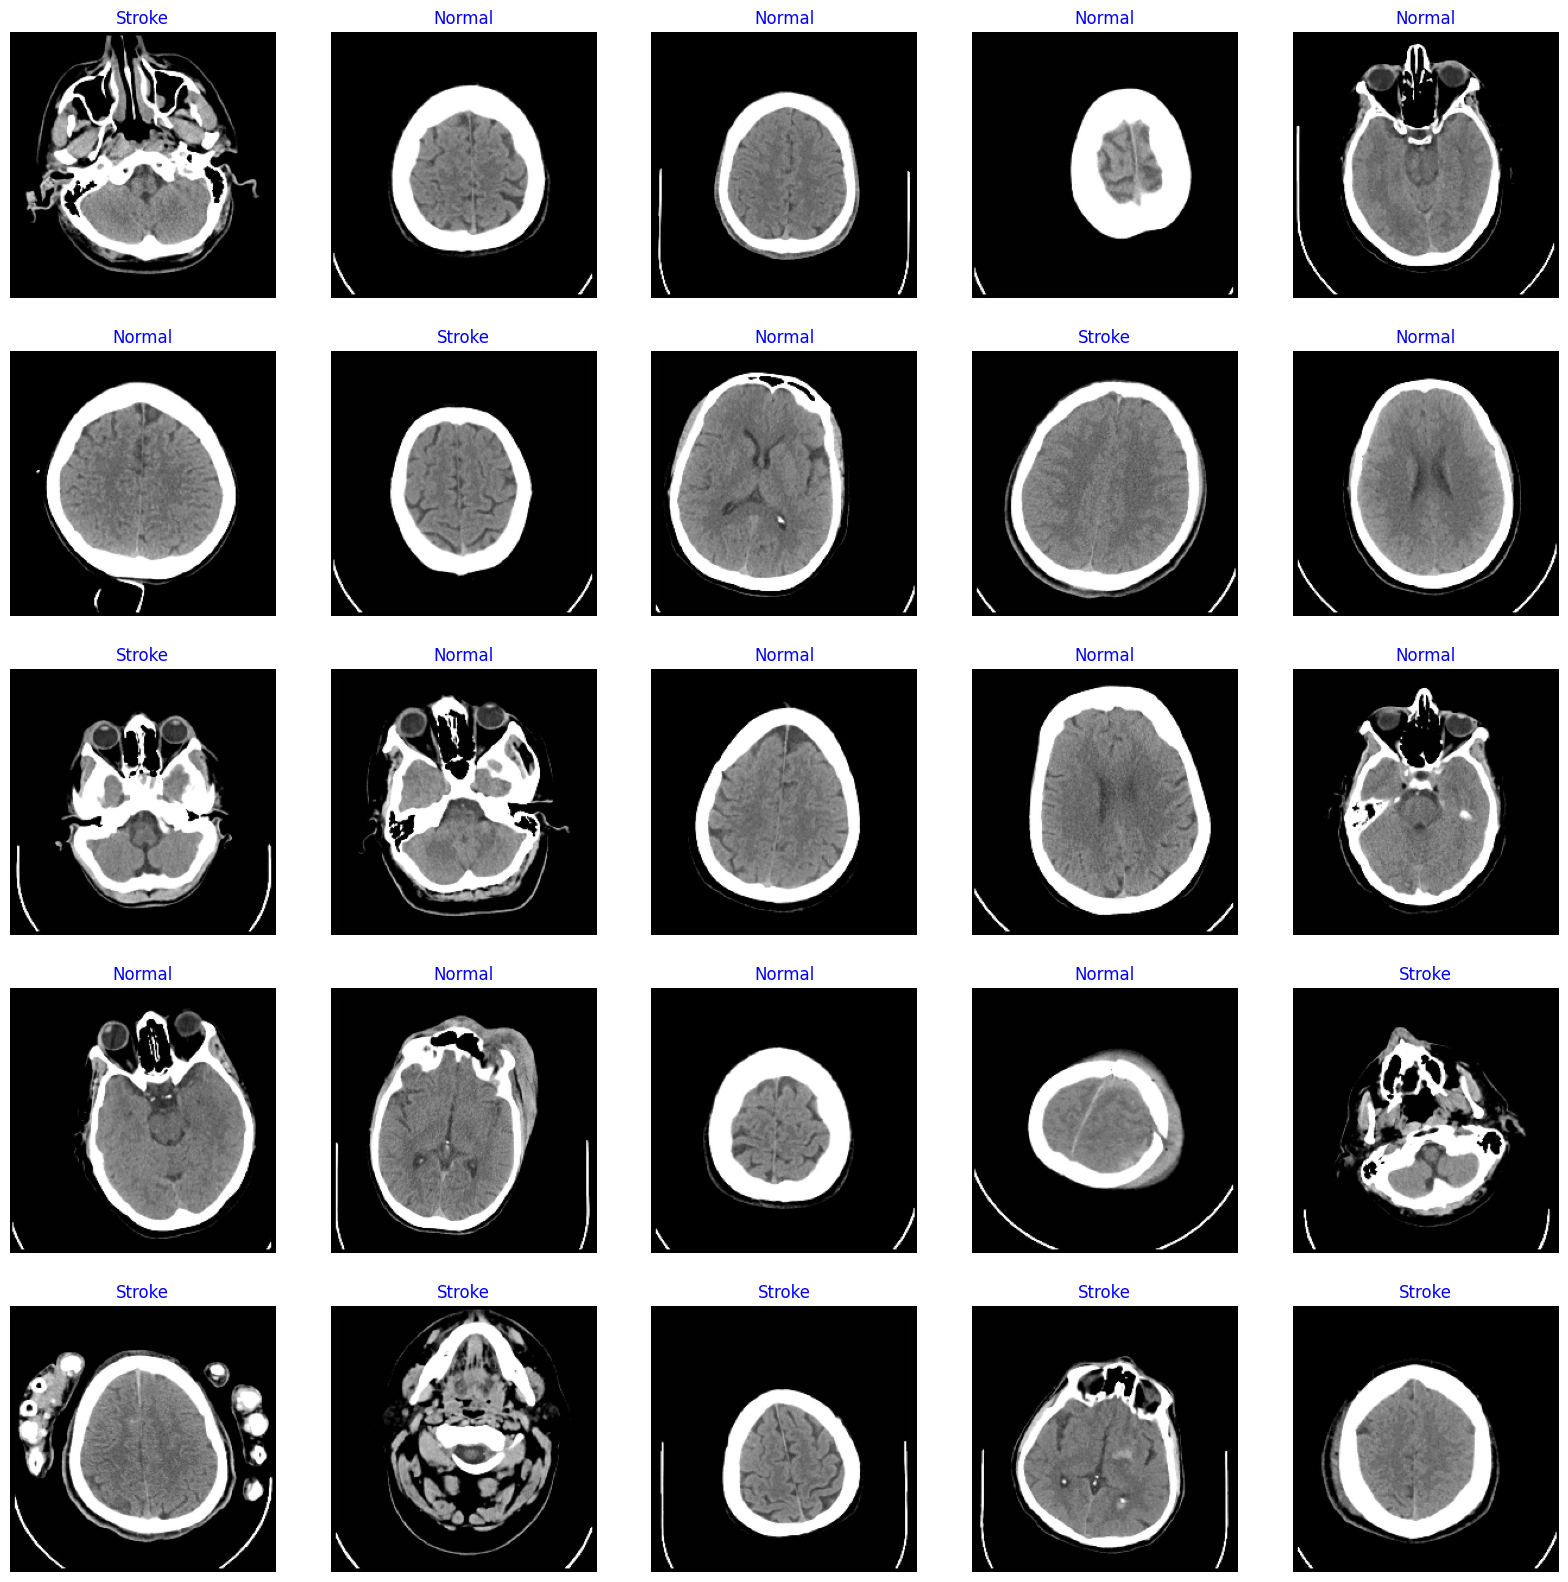

In [9]:
train_directory = 'Train'
validation_directory = 'Validation'
test_directory = 'Test'

train_dataframe, validation_dataframe, test_dataframe = create_df(train_directory, validation_directory, test_directory)

batch_size = 40

train_generator, validation_generator, test_generator = create_data_generators(train_dataframe, validation_dataframe, test_dataframe, batch_size)
display_images(train_generator)

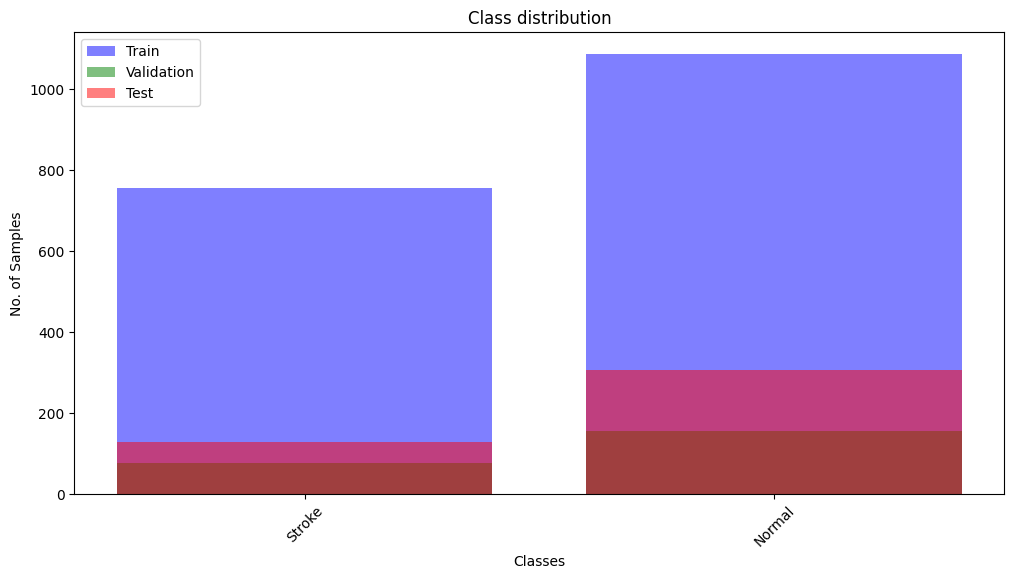

Train class counts: {'Stroke': 756, 'Normal': 1087}
Validation class counts: {'Stroke': 78, 'Normal': 157}
Test class counts: {'Stroke': 130, 'Normal': 307}


In [10]:
def count_classes(directory):
    classes = []
    counts = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            classes.append(class_folder)
            counts.append(len(os.listdir(class_path)))
    return classes, counts


train_classes, train_counts = count_classes(train_directory)
val_classes, val_counts = count_classes(validation_directory)
test_classes, test_counts = count_classes(test_directory)


plt.figure(figsize=(12, 6))
plt.bar(train_classes, train_counts, color='b', alpha=0.5, label='Train')
plt.bar(val_classes, val_counts, color='g', alpha=0.5, label='Validation')
plt.bar(test_classes, test_counts, color='r', alpha=0.5, label='Test')
plt.xlabel('Classes')
plt.ylabel('No. of Samples')
plt.title('Class distribution')
plt.legend()
plt.xticks(rotation=45)
plt.show()


print(f"Train class counts: {dict(zip(train_classes, train_counts))}")
print(f"Validation class counts: {dict(zip(val_classes, val_counts))}")
print(f"Test class counts: {dict(zip(test_classes, test_counts))}")

Found 1843 images belonging to 2 classes.
Found 235 images belonging to 2 classes.
Found 437 images belonging to 2 classes.
Original class distribution in training set:
Counter({0: 1087, 1: 756})
after oversampling:
Counter({0: 1087, 1: 1087})


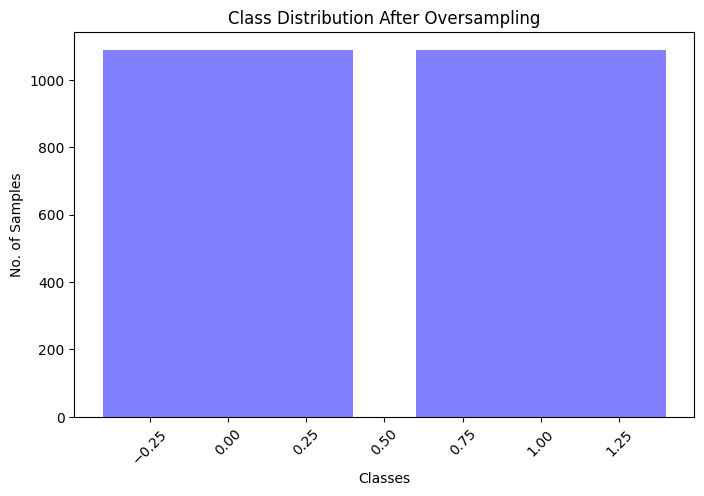

In [11]:
batch_size = 32
image_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_gen = valid_test_datagen.flow_from_directory(
    validation_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_gen = valid_test_datagen.flow_from_directory(
    test_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

counter = Counter(train_gen.classes)
print("Original class distribution in training set:")
print(counter)

train_file_paths = np.array(train_gen.filepaths)
train_labels = train_gen.classes.reshape(-1, 1)  

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
train_file_paths_resampled, train_labels_resampled = oversampler.fit_resample(train_file_paths.reshape(-1, 1), train_labels)

counter_resampled = Counter(train_labels_resampled.flatten())
print("after oversampling:")
print(counter_resampled)

plt.figure(figsize=(8, 5))
plt.bar(counter_resampled.keys(), counter_resampled.values(), color='b', alpha=0.5)
plt.xlabel('Classes')
plt.ylabel('No. of Samples')
plt.title('Class Distribution After Oversampling')
plt.xticks(rotation=45)
plt.show()

In [12]:
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
train_file_paths_resampled, train_labels_resampled = oversampler.fit_resample(train_file_paths.reshape(-1, 1), train_labels)

In [13]:
train_file_paths_resampled, train_labels_resampled = shuffle(train_file_paths_resampled, train_labels_resampled, random_state=42)

train_labels_resampled = train_labels_resampled.astype(str)

# Data Generators
batch_size = 32
image_size = (224, 224)
num_classes = 2  # Update this based on your dataset

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_gen = valid_test_datagen.flow_from_directory(
    validation_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_gen = valid_test_datagen.flow_from_directory(
    test_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

Found 1843 images belonging to 2 classes.
Found 235 images belonging to 2 classes.
Found 437 images belonging to 2 classes.


In [14]:
# Model definition
def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    'Train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')  

valid_gen = valid_datagen.flow_from_directory(
    'Validation',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')  


base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(train_gen.class_indices), activation='softmax')(x)  


# Compile and train the model
input_shape = (image_size[0], image_size[1], 3)
model = create_model(input_shape, num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size)


Found 1843 images belonging to 2 classes.
Found 235 images belonging to 2 classes.


2025-02-24 08:50:18.300167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-24 08:50:18.423714: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
52/57 [==========================>...] - ETA: 7s - loss: 1.2426 - accuracy: 0.6226

In [ ]:
predictions = Dense(2, activation='softmax')(x)  
train_gen = train_datagen.flow_from_directory(
    'Train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=10,  
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size
)

loss, accuracy = model.evaluate(test_gen)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

In [ ]:
def plot_training(history):
   
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()


plot_training(history)


In [ ]:
ts_length = len(test_gen)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
# Display Confusion Matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
# Generate predictions
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix and classification report
target_names = ['hemorrhagic', 'ischaemic']
cm = confusion_matrix(test_gen.classes, y_pred_classes)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=target_names, title='Confusion Matrix')

print(classification_report(test_gen.classes, y_pred_classes, target_names=target_names))
plt.show()

In [ ]:
# Plotting training metrics
def plot_training_metrics(history):
    training_accuracy = history.history['accuracy']
    training_loss = history.history['loss']
    validation_accuracy = history.history['val_accuracy']
    validation_loss = history.history['val_loss']

    best_epoch_loss = np.argmin(validation_loss) + 1
    best_epoch_accuracy = np.argmax(validation_accuracy) + 1
    lowest_val_loss = validation_loss[best_epoch_loss - 1]
    highest_val_acc = validation_accuracy[best_epoch_accuracy - 1]

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')
    epochs = range(1, len(training_accuracy) + 1)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, 'r', label='Training Loss')
    plt.plot(epochs, validation_loss, 'g', label='Validation Loss')
    plt.scatter(best_epoch_loss, lowest_val_loss, s=150, c='blue', label=f'Best Epoch = {best_epoch_loss}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, 'r', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'g', label='Validation Accuracy')
    plt.scatter(best_epoch_accuracy, highest_val_acc, s=150, c='blue', label=f'Best Epoch = {best_epoch_accuracy}')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_metrics(history)

In [ ]:
model_name = 'StrokePredModel'
subject = 'Stroke Prediction'
save_path = ''
acc = test_score[1] * 100

save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved successfully as {model_save_loc}')

In [ ]:
model = load_model(model_save_loc)

In [ ]:
explainer = LimeImageExplainer()

In [ ]:
def preprocess_image(image):

    img = keras_image.array_to_img(image)
    img = img.resize((224, 224))    
    img_array = keras_image.img_to_array(img) / 255.0
    return img_array

explainer = LimeImageExplainer()

num_samples = 5  
for _ in range(num_samples):
 
    images, _ = next(test_gen)  
    image = images[0]   

    preprocessed_image = preprocess_image(image)
 
    preds = model.predict(np.array([preprocessed_image]))
    pred_class = np.argmax(preds)
  
    explanation = explainer.explain_instance(preprocessed_image, model.predict, top_labels=1, hide_color=0, num_samples=1000)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.show()


In [ ]:
import os
import pandas as pd

class_dict = train_gen.class_indices
height = []
width = []
for _ in range(len(class_dict)):
    height.append(image_size[0])
    width.append(image_size[1])

Index_series = pd.Series(list(class_dict.values()), name='class_index')
Class_series = pd.Series(list(class_dict.keys()), name='class')
Height_series = pd.Series(height, name='height')
Width_series = pd.Series(width, name='width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis=1)

# Define save_path; update it as per your requirement
save_path = '/kaggle/working'  # Kaggle working directory

subject = 'Stroke Prediction'
csv_name = f'{subject}-Gov_dissertation.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index=False)
print(f'class csv file was saved as {csv_save_loc}')
